In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

In [59]:
df = pd.read_excel('../data/MERGED_DATA_INTERPOLATED2.xlsx', sheet_name='MERGE')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


---

In [60]:
columns = list(df.columns)

print(columns)
# df["DATUM"] = df["DATUM"].apply(lambda datum: datum.toordinal())
# df["DATUM"] = df["DATUM"].apply(lambda datum: datum - df.loc[0, "DATUM"])
df['DATUM'] = pd.to_datetime(df['DATUM'])

# we drop the "time" and "zicht" columns
time_loc_columns = ['LOC_CODE', 'DATUM']
abiotic_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']

abiotic_df = df[time_loc_columns + abiotic_columns]

abiotic_df.head()

['LOC_CODE', 'DATUM', 'TIJD', 'ZS [mg/l]', 'ZICHT [dm]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]', '    Q', 'PAR [J/m2d]', 'PAR [kJ/m2d]', 'kPAR_7d', 'kPAR_14d', 'DIN', 'DIN:SRP', 'DIN:SI', 'SRP:SI', 'IM [Jm2d]', 'Agl', 'Dbr', 'Ezo', 'Gde', 'Oau', 'Omo', 'Orh', 'Osi', 'Ram', 'Rse', 'Tec', 'Tle', 'Tni', 'Tro', 'Dle', 'Etr', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pbr', 'Pha', 'Stu', 'Kgl', 'Oro', 'Tor', 'Cdi', 'Cra', 'Ore', 'Ata', 'Cfu', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Dip', 'Csu', 'Mnu', 'Pco', 'Cdeb', 'Cwa', 'Pba', 'Dac', 'Ptr', 'Lun', 'Nsi', 'Rst', 'Pst', 'Acn', 'Tno', 'Ccu', 'Pan', 'Gfa', 'Hta', 'Dsp', 'Psu', 'Cei', 'Ndi', 'Cda', 'Dro', 'Cha', 'Pac', 'Cau', 'Coc', 'Pte', 'Edu', 'Mpe', 'Pde', 'Plo', 'Dpu', 'Rte', 'Fja', 'Hak', 'Mhe', 'Dno', 'Dat', 'interpolated_columns']


,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l]
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2


## Creating train and test split

In [61]:
location_groups = abiotic_df.groupby("LOC_CODE")

train_test_dict = {}
for name, loc_df in location_groups:
    # extract year and month and put inside new column
    loc_df['YearMonth'] = loc_df['DATUM'].dt.to_period('M')
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    # calculate mean over month
    loc_df_mean = loc_df.groupby('YearMonth').mean().reset_index()
    
    train_test_dict[name] = loc_df_mean


## Scaling data before use

In [62]:
def scale_data(data, parameter_columns):
    # we gotta normalize the values for the different variables prior to analysis
    abio_data_scaler = MinMaxScaler()

    abio_data_scaler.fit(data[parameter_columns])
    data[parameter_columns] = abio_data_scaler.transform(data[parameter_columns])


for loc_name, data in train_test_dict.items():
    scale_data(data, abiotic_columns)

## Transforming data into labeled data and creating train/test split

In [63]:
train_test_ratio = 0.7

def window_sampler(df, window, parameter_columns):
	X = []
	Y = []
	for i in range(0, len(df) - window):
		history = []
		for j in range(0, window):
			history.append(list(df[parameter_columns].iloc[(i + j)]))
		X.append(history)
		Y.append(df[parameter_columns].iloc[i + window].values)
	return np.array(X), np.array(Y)

for i, (loc_name, data) in enumerate(train_test_dict.items()):
	print(f"LOC_NAME: {loc_name} BUSY ({i}/{len(train_test_dict) - 1})")
	X, Y = window_sampler(data, 6, abiotic_columns)

	tuple_list = list(zip(X, Y))

	print("sample pairs: ", len(tuple_list))

	X, Y = zip(*tuple_list)

	train_x = np.asarray(X[:int(train_test_ratio * len(X))])
	train_y = np.asarray(Y[:int(train_test_ratio * len(Y))])
	test_x = np.asarray(X[int(train_test_ratio * len(X)):])
	test_y = np.asarray(Y[int(train_test_ratio * len(Y)):])

	train_test_dict[loc_name] = ((train_x, train_y), (test_x, test_y), data["YearMonth"])
	print(f"LOC_NAME: {loc_name} FINISHED\n")


LOC_NAME: DANTZGT BUSY (0/26)
sample pairs:  364
LOC_NAME: DANTZGT FINISHED

LOC_NAME: DREISR BUSY (1/26)
sample pairs:  365
LOC_NAME: DREISR FINISHED

LOC_NAME: GOERE6 BUSY (2/26)
sample pairs:  356
LOC_NAME: GOERE6 FINISHED

LOC_NAME: GROOTGND BUSY (3/26)
sample pairs:  362
LOC_NAME: GROOTGND FINISHED

LOC_NAME: HANSWGL BUSY (4/26)
sample pairs:  365
LOC_NAME: HANSWGL FINISHED

LOC_NAME: HUIBGOT BUSY (5/26)
sample pairs:  362
LOC_NAME: HUIBGOT FINISHED

LOC_NAME: LODSGT BUSY (6/26)
sample pairs:  365
LOC_NAME: LODSGT FINISHED

LOC_NAME: MARSDND BUSY (7/26)
sample pairs:  363
LOC_NAME: MARSDND FINISHED

LOC_NAME: NOORDWK10 BUSY (8/26)
sample pairs:  362
LOC_NAME: NOORDWK10 FINISHED

LOC_NAME: NOORDWK2 BUSY (9/26)
sample pairs:  358
LOC_NAME: NOORDWK2 FINISHED

LOC_NAME: NOORDWK20 BUSY (10/26)
sample pairs:  359
LOC_NAME: NOORDWK20 FINISHED

LOC_NAME: NOORDWK70 BUSY (11/26)
sample pairs:  359
LOC_NAME: NOORDWK70 FINISHED

LOC_NAME: ROTTMPT3 BUSY (12/26)
sample pairs:  274
LOC_NAME: ROT

## Defining the LSTM model

In [64]:
LSTM_units = 256
dropout_prob = 0.2
output_dimensionality = 11
loss = "MeanSquaredError"
metrics = ["MAE"]
optimizer = "Adam"
activation = "linear"
input_shape = (train_x[0].shape[0], train_x[0].shape[1])


LSTM_multivariate = keras.Sequential()
LSTM_multivariate.add(Input(shape=(input_shape[0], input_shape[1])))
LSTM_multivariate.add(keras.layers.LSTM(LSTM_units))
LSTM_multivariate.add(keras.layers.Dropout(dropout_prob))
LSTM_multivariate.add(keras.layers.Dense(output_dimensionality, activation=activation))
LSTM_multivariate.compile(loss = loss, metrics=metrics, optimizer=optimizer)
LSTM_multivariate.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 256)            │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,259 (1.06 MB)

 Trainable params: 277,259 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [65]:
# print(len(train_test_dict["DANTZGT"][0]), len(train_test_dict["DANTZGT"][0][0]), len(train_test_dict["DANTZGT"][0][1]))
# print(len(train_test_dict["DANTZGT"][0][1][-1]))

X_train = train_test_dict["DANTZGT"][0][0]
y_train = train_test_dict["DANTZGT"][0][1]

# X_train = np.moveaxis(X_train, 1, -1)

print(X_train.shape, y_train.shape)

history = LSTM_multivariate.fit(X_train, y_train, epochs=50)


(254, 6, 11) (254, 11)
Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MAE: 0.2466 - loss: 0.1076 
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.1628 - loss: 0.0421 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 0.1355 - loss: 0.0332
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 0.1192 - loss: 0.0255
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.1082 - loss: 0.0208 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.1084 - loss: 0.0216 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 0.1044 - loss: 0.0201
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 0.1027 - loss: 0.0194
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - MAE: 0.1016 - loss: 0.0191
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 0.1011 - loss: 0.0191
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.0986 - loss: 0.0178 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.0970 - loss: 0.0178 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.0980 - loss: 0.0177

## Plotting results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(110,)


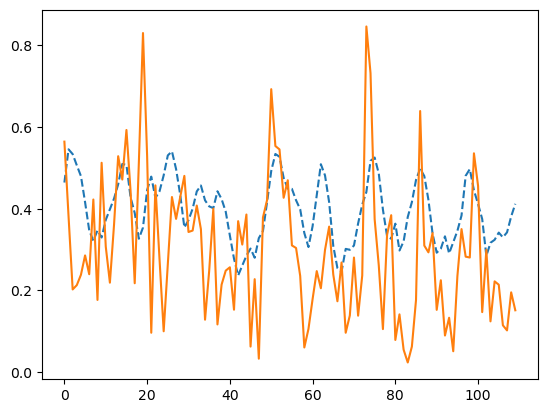

In [67]:
# dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
# dataFrame.set_index('Date', inplace=True)

dates = train_test_dict["DANTZGT"][2]
dates = dates.map(lambda x: x.year + ((x.month - 1) / 12))

X_test = train_test_dict["DANTZGT"][1][0]
y_test = train_test_dict["DANTZGT"][1][1]

predicted_values = LSTM_multivariate.predict(X_test)
print(predicted_values[:, 0].shape)
 
d = {
    'Predicted': predicted_values[:, 0],
    'Actual': y_test[:, 0]
}

xs = list(range(len(predicted_values[:, 0])))
plt.plot(xs, d['Predicted'], linestyle='--')
plt.plot(xs, d['Actual'])

# d = pd.DataFrame(d)

# d.index = dates[-len(y_test):]
 
# fig, ax = plt.subplots(figsize=(10, 6))
# #  highlight the  forecast
# highlight_start = int(len(d) * 0.9)  
# highlight_end = len(d) - 1  # Adjusted to stay within bounds

# # Plot the actual values
# plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
 
# # Plot predicted values with a dashed line
# # plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')
 
# # Highlight the forecasted portion with a different color
# plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
 
# plt.title('Multivariate Time-Series forecasting using LSTM')
# plt.xlabel('Dates')
# plt.ylabel('Values')
# ax.legend()
# plt.show()